# Import Libraries & Data (review_polarity)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.6 MB/s eta 0:00:00


In [4]:
!pip install tqdm pandas nltk pyspellchecker emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 23.5 MB/s eta 0:00:00


In [14]:
from tqdm import tqdm
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import string
import re
from spellchecker import SpellChecker
import emoji
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import hstack
import contractions
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC

In [6]:
base_path = '/content/drive/MyDrive/txt_sentoken'
neg_path = os.path.join(base_path, 'neg')
pos_path = os.path.join(base_path, 'pos')

neg_reviews = []
for file in os.listdir(neg_path):
    with open(os.path.join(neg_path, file), 'r', encoding='utf-8') as f:
        neg_reviews.append(f.read())

pos_reviews = []
for file in os.listdir(pos_path):
    with open(os.path.join(pos_path, file), 'r', encoding='utf-8') as f:
        pos_reviews.append(f.read())

df_txt_sentoken = pd.DataFrame({
    'text': neg_reviews + pos_reviews,
    'label': [0]*len(neg_reviews) + [1]*len(pos_reviews)
})

print(df_txt_sentoken.head())
print(df_txt_sentoken['label'].value_counts())

                                                text  label
0  plot : two teen couples go to a church party ,...      0
1  the happy bastard's quick movie review \ndamn ...      0
2  it is movies like these that make a jaded movi...      0
3   " quest for camelot " is warner bros . ' firs...      0
4  synopsis : a mentally unstable man undergoing ...      0
label
0    1000
1    1000
Name: count, dtype: int64


# Preprocessing

In [26]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import string
import re
from spellchecker import SpellChecker
import emoji

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

slang_dict = {
    "gr8": "great",
    "luv": "love",
    "bff": "best friend",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "brb": "be right back",
    "idk": "i don't know",
    "smh": "shaking my head"
}

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if unknown

def handle_negations(text):
    negations = ["not", "no", "never", "none", "n't"]
    words = text.split()
    for i, word in enumerate(words):
        if word in negations and i + 1 < len(words):
            words[i + 1] = f"not_{words[i + 1]}"  # Prefix with 'not_'
    return " ".join(words)

def handle_emojis(text):
    return emoji.demojize(text)

def correct_spelling(text):
    words = text.split()
    corrected_words = []
    for word in words:
        # If the word is not in the stopwords list, correct the spelling
        if word not in stop_words:
            corrected_word = spell.correction(word)
            if corrected_word is not None:
                corrected_words.append(corrected_word)
            else:
                corrected_words.append(word)  # If no correction found, keep the word as is
        else:
            corrected_words.append(word)
    return " ".join(corrected_words)

def handle_slang(text):
    words = text.split()
    return " ".join([slang_dict.get(word, word) for word in words])

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove HTML Tags
    text = re.sub(r'<.*?>', '', text)

    # 3. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 4. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 5. Handle Emojis
    text = handle_emojis(text)

    # 6. Handle Negations
    text = handle_negations(text)

    # 7. Correct spelling
    #text = correct_spelling(text)

    # 8. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 9. Remove Hashtags and Mentions (for social media data)
    text = re.sub(r'@\w+|#\w+', '', text)  # Removes mentions and hashtags

    # 10. Handle Slang
    text = handle_slang(text)

    # 11. Tokenize
    tokens = word_tokenize(text)

    # 12. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 13. Lemmatization with correct POS tag
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

    return ' '.join(tokens)

from tqdm import tqdm

tqdm.pandas()

# Apply the preprocessing
df_txt_sentoken['clean_text'] = df_txt_sentoken['clean_text'].progress_apply(preprocess_text)

final_df = df_txt_sentoken[['clean_text', 'label']]

print(final_df.head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 2000/2000 [01:10<00:00, 28.20it/s]

                                          clean_text  label
0  plot two teen couple go church party drink dri...      0
1  happy bastard quick movie review damn yk bug g...      0
2  movie like make jade movie viewer thankful inv...      0
3  quest camelot warner bros first featurelength ...      0
4  synopsis mentally unstable man undergo psychot...      0


In [27]:
final_df.shape

(2000, 2)

# Feature Extraction

In [28]:
# TF-IDF Vectorization (Unigrams + Bigrams)
tfidf = TfidfVectorizer(min_df=5, max_features=10000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(final_df['clean_text'])
y = final_df['label']

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Model

In [29]:
# ==========================
# Logistic Regression
# ==========================
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print("Best Logistic Regression (GridSearchCV) Accuracy:", grid.score(X_test, y_test))

Best Logistic Regression (GridSearchCV) Accuracy: 0.8475


In [30]:
# ==========================
# LinearSVC
# ==========================
svc = LinearSVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print("LinearSVC Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Classification Report:\n", classification_report(y_test, y_pred_svc))

# ==========================
# Random Forest
# ==========================
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

LinearSVC Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.84       200
           1       0.82      0.87      0.84       200

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400

Random Forest Accuracy: 0.8325
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.84       200
           1       0.86      0.80      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



In [31]:
# ==========================
# Ensemble Learning
# ==========================
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000)),
    ('nb', MultinomialNB()),
    ('rf', RandomForestClassifier())
], voting='soft')  # Use 'hard' or 'soft'

ensemble.fit(X_train, y_train)
preds = ensemble.predict(X_test)
print("Ensemble Accuracy:", accuracy_score(y_test, preds))

Ensemble Accuracy: 0.85


In [32]:
import joblib

# Save the trained ensemble model
joblib.dump(ensemble, 'ensemble_model.pkl')

print("Model saved successfully!")

Model saved successfully!


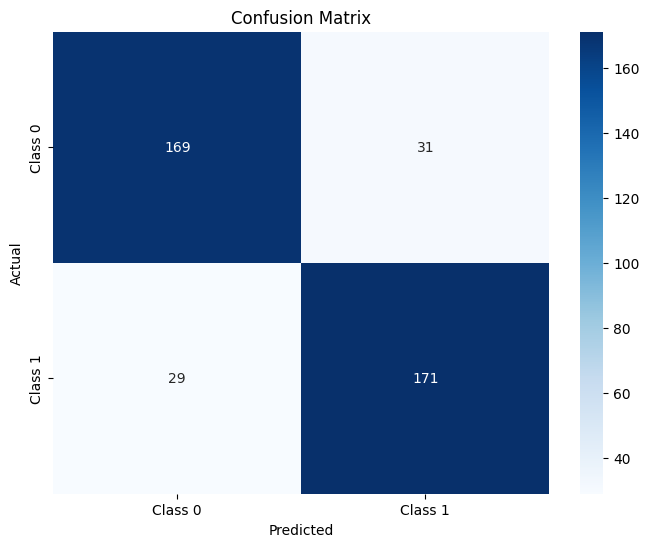

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, preds)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       200
           1       0.85      0.85      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

